# Benchmarking data acquisition

## Libraries

In [3]:
## Standard python
import os
import sys
import glob
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
from collections import defaultdict

## Pyspark libraries
from pyspark.sql import SparkSession

## Mask credentials
import configparser

## Functions

In [5]:
sys.path.append(os.path.join(os.getcwd(), 'Functions'))

# DATA IMPORT AND INSPECTION
from data_unpacking_and_conversion import data_unpacking_and_conversion
from dataset_overall_cleansing     import dataset_overall_cleansing
from muon_passages                 import muon_passages
from hit_time_information          import hit_time_information
from scintillation_intervals       import scintillation_intervals
from layer_cleansing               import layer_cleansing
from further_noise_considerations  import further_noise_considerations

# SPATIAL COORDINATES
from coordinate_evaluation         import coordinate_evaluation
from left_or_right_evaluation      import left_or_right_evaluation
from z_evaluation                  import z_evaluation

# LOCAL FIT
from df_new_columns                import df_new_columns
from df_local_creation             import df_local_creation

# GLOBAL FIT
from df_global_creation            import df_global_creation

# EXTENDED GLOBAL FIT
from df_global_ex_creation         import df_global_ex_creation

# DETECTOR ANGULAR RESOLUTION
from detector_angular_resolution   import detector_angular_resolution

## Configurations

Here we set all the parameters for the configuration of the spark session.

In [10]:
executors  = [3]
cores      = [4]
max_cores  = [12]
memory     = ["5000m"]
partitions = [42]

Here we write all the function useful for the data acquisition for each run:

* `get_nrun()` returns the number of the run for that configuration. It's useful since there are some overlapping of configurations in the benchmarking analysis, so we don't want to overwrite in the same file and lose data.
* `write_time()` is a shortcut to write the time of computation in the file on a new string.

In [13]:
def get_nrun(executors, cores, max_cores, memory, partitions, directory):
    
    pattern = re.compile(rf"E{executors}-C{cores}-MC{max_cores}-M{memory}-P{partitions}_Run-(\d+)\.txt")
    files = os.listdir(directory)
    matches = [int(m.group(1)) for f in files if (m := pattern.match(f))]

    if not matches:
        return 1
      
    return max(matches) + 1

def write_time(f, line):
    f.write(line + '\n')

## Run of the code

This is where the calculations takes place. The steps are the following:

1. `cleanup_and_start.sh` is a script that cleans up the directories, deletes all logs and temporary files in all the workers and finally starts the cluster.
2. All configurations are evaluated within a nested for cycle, where the Spark session is started using the parameter specified for that iteration.
3. We then open the file calling it with a pattern that specifies the configuration for the data inside:
  
$$
\text{\texttt{E\{executors\}-C\{cores\}-MC\{maximum\ cores\}-M\{memory\}-P\{partitions\}\_Run-\{run\}.txt}}
$$

4. We import the files from the CloudVeneto container and begin to start measuring time.
5. The original notebook has been broken down into eleven functions that are used here in the cycles. All these functions consider only pure calculations and avoid all the printing and plotting that were used in the delivered notebook. Also, all the actions are not triggered in the notebook, since each of them is explicitly triggered with a `.count()`, as it can be seen below. The only non-triggering transformation that has been removed from the functions is the `.persist()`, because in this way we can easily choose either to use the persists or not directly inside the cycles.
6. At the end of each iteration we close the file, stop the Spark session and clean up all the directories with the `only_cleanup.sh` script.

In [ ]:
!bash cleanup_and_start.sh

for (e, c, mc) in zip(executors, cores, max_cores):
    for m in memory:
        for p in partitions:

            
            ###################################################################################################################
            ############################################## SPARK SESSION ######################################################
            ###################################################################################################################

            
            config = configparser.ConfigParser()
            config.read('./aws_credentials.txt')
            access_key = config.get('DEFAULT', 'access_key')
            secret_key = config.get('DEFAULT', 'secret_key')
            
            spark = SparkSession.builder \
                .master("spark://master:7077")\
                .appName("MAPD B Project")\
                .config('spark.jars.packages', 'org.apache.hadoop:hadoop-common:3.3.4')\
                .config('spark.jars.packages', 'org.apache.hadoop:hadoop-aws:3.3.4')\
                .config('spark.executor.instances', e)\
                .config("spark.executor.cores", c)\
                .config('spark.cores.max', mc)\
                .config("spark.executor.memory", m)\
                .config("spark.sql.shuffle.partitions", p)\
                .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
                .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false")\
                .config('spark.hadoop.fs.s3a.aws.credentials.provider', 'org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider')\
                .config('spark.hadoop.fs.s3a.access.key', str(access_key))\
                .config('spark.hadoop.fs.s3a.secret.key', str(secret_key))\
                .config('spark.hadoop.fs.s3a.endpoint', 'https://cloud-areapd.pd.infn.it:5210')\
                .config("spark.hadoop.fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem") \
                .config("spark.hadoop.fs.s3a.metadatastore.impl", "org.apache.hadoop.fs.s3a.s3guard.NullMetadataStore") \
                .config("spark.hadoop.fs.s3a.path.style.access", "true") \
                .config("spark.hadoop.fs.s3a.connection.ssl.enabled","false") \
                .config("com.amazonaws.sdk.disableCertChecking","true") \
                .getOrCreate()

            sc = spark.sparkContext
            spark.sparkContext.setLogLevel("ERROR")

            
            ###################################################################################################################
            ############################################## FILE CREATION ######################################################
            ###################################################################################################################

            
            nrun = get_nrun(e, c, mc, m, p, "./Runs")
            file_name = os.path.join("./Runs", "E" + str(e) + "-C" + str(c) + "-MC" + str(mc) + "-M" + m + "-P" + str(p) + "_Run-" + str(nrun) + ".txt")
            
            f = open(file_name, 'w')

            
            ###################################################################################################################
            ########################################## DATA IMPORT AND INSPECTION #############################################
            ###################################################################################################################

            
            df = data_unpacking_and_conversion(sc)
            print(f"Run start ({file_name})")

            start_time = time.time()

            ########################################### DATASET OVERALL CLEANSING #############################################
            df = dataset_overall_cleansing(df)
            df.count()
            write_time(f, f"{time.time() - start_time}")
            print("Dataset overall cleansing")

            ############################################### MUON PASSAGES #####################################################
            df = muon_passages(df)
            df.count()
            write_time(f, f"{time.time() - start_time}")
            print("Muon passages")

            ############################################ HIT TIME INFORMATION #################################################
            df = hit_time_information(df)
            df.count()
            write_time(f, f"{time.time() - start_time}")
            print("Hit time information")

            ########################################### SCINTILLATION INTERVALS ###############################################
            df = scintillation_intervals(df)
            df.count()
            write_time(f, f"{time.time() - start_time}")
            print("Scintillation intervals")

            ############################################### LAYER CLEANSING ###################################################
            df = layer_cleansing(df)
            df.count()
            write_time(f, f"{time.time() - start_time}")
            print("Layer cleansing")
            
            ########################################## FURTHER NOISE CONSIDERATIONS ###########################################
            df = further_noise_considerations(df)
            #df = df.persist()
            df.count()
            write_time(f, f"{time.time() - start_time}")
            print("Further noise considerations")


            ###################################################################################################################
            ######################################### TRACK MUONS RECONSTRUCTION ##############################################
            ###################################################################################################################


            ############################################ COORDINATE EVALUATION ################################################
            df = coordinate_evaluation(df)
            #df = df.persist()
            df.count()
            print("Coordinate evaluation")
            ########################################## LEFT OR RIGHT EVALUATION ###############################################
            df = left_or_right_evaluation(df)
            #df = df.persist()
            df.count()
            print("Left or right evaluation")
            ############################################## Z EVALUATION #######################################################
            df = z_evaluation(df)
            #df = df.persist()
            df.count()
            write_time(f, f"{time.time() - start_time}")
            print("Z evaluation")


            ############################################# DF NEW COLUMNS ######################################################
            df = df_new_columns(df)
            #df = df.persist()
            df.count()
            print("df new columns")
            ########################################### DF_LOCAL CREATION #####################################################
            df_local = df_local_creation(df)
            df_local = df_local.persist()
            df_local.count()
            write_time(f, f"{time.time() - start_time}")
            print("df_local creation")


            ########################################## DF_GLOBAL CREATION #####################################################
            df_global = df_global_creation(df_local)
            df_global = df_global.persist()
            df_global.count()
            write_time(f, f"{time.time() - start_time}")
            print("df_global creation")


            ###################################### DF_GLOBAL_EXTENDED CREATION ################################################
            df_global_ex = df_global_ex_creation(df)
            df_global_ex.count()
            write_time(f, f"{time.time() - start_time}")
            print("df_global_extended creation")


            ###################################### DETECTOR ANGULAR RESOLUTION ################################################
            angle_diff = detector_angular_resolution(df_local, df_global)
            mu, s = stats.norm.fit(angle_diff)
            write_time(f, f"{time.time() - start_time}")
            print("Detector angular resolution")
            
            
            ###################################################################################################################
            ############################################## END OF THE RUN #####################################################
            ###################################################################################################################

            
            f.close()
            spark.stop()
            sc.stop()

            !bash only_cleanup.sh

# Benchmarking results

## Functions and labels

Here we create some important features for our analysis:

* `remove_run()` rename the files by removing the "-Run-{run}" part. We use it only once, so we did not save it in the final version of the notebook.
* `get_data()` gets the data from a directory and returns it as a dictionary, where the key is the name of the file and the item is a list made by all the lines inside the file (time measures).
* `get_confs()` returns a list made by lists in which are contained, in order, the number of executors, the number of cores per executor, the numer of cores in total, the total memory per executor and the number of partitions.
* `x_labels` is a list of all the names of the steps associated to the time measures.

In [20]:
def remove_run(dir):
    
    pattern_run = re.compile(r'_Run-\d+') 
    
    for filename in os.listdir(dir):
        
        if re.match(r'E.*-C.*-MC.*-M.*m-P.*_Run-\d+\.txt', filename):
            
            new_filename = pattern_run.sub('', filename)
            os.rename(os.path.join(dir, filename), os.path.join(dir, new_filename))

def get_data(dir):

    os.chdir(dir)
    file_pattern = "E*-C*-MC*-M*m-P*.txt"
    files = glob.glob(file_pattern)

    data = {}
        
    for file in files:
        with open(file, 'r') as f:
            rows = [float(num) for line in f for num in line.split()]
            data[file] = rows

    return data
                

def get_confs(executors, cores, max_cores, memory, partitions):

    confs = []

    for e, c, mc in zip(executors, cores, max_cores):
        for m in memory:
            for p in partitions:
                confs.append([e, c, mc, m, p])

    return confs

x_labels = ["Overall cleansing", "Muon passages", "Hit time info", "Scint intervals", "Layer cleansing", "Further noise", "Spatial coord", "Local tracks", "Global tracks", "Ext global tracks", "Angular resolution"]

## Executors and cores analysis

The first thing we are interested in our analysis is how the performances of our algorithm change by changing the number of executors and the number of cores associated to each executor.

We know that the cluster provided to us is composed by three machines, each one with $4$ cores and approximately $6800 \ MB$ of memory. This means that the total number of cores available to us is twelve. We then consider all the possible configurations with a total number of cores that goes from $1$ to $12$:

* $1$ core: $1$ executor with $1$ core
* $2$ cores:
  1. $2$ executors with $1$ core
  2. $1$ executor with $2$ cores
* $3$ cores:
  1. $3$ executors with $1$ core
  2. $1$ executor with $3$ cores
* $4$ cores:
  1. $4$ executors with $1$ core
  2. $2$ executors with $2$ cores
  3. $1$ executor with $4$ cores
* $5$ cores: $5$ executors with $1$ core
* $6$ cores:
  1. $6$ executors with $1$ core
  2. $3$ executors with $2$ cores
  3. $2$ executors with $3$ cores
* $7$ cores: $7$ executors with $1$ core
* $8$ cores:
  1. $8$ executors with $1$ core
  2. $4$ executors with $2$ cores
  3. $2$ executors with $4$ cores
* $9$ cores:
  1. $9$ executors with $1$ core
  2. $3$ executors with $3$ cores
* $10$ cores:
  1. $10$ executors with $1$ core
  2. $5$ executors with $2$ cores
* $11$ cores: $11$ executors with $1$ core
* $12$ cores:
  1. $12$ executors with $1$ core
  2. $6$ executors with $2$ cores
  3. $4$ executors with $3$ cores
  4. $3$ executors with $4$ cores
 
We wrote the function `executors_and_cores_plot()` in order to plot all the performances for each configuration following every one of the eleven steps. It also plots the average final time per total number of cores (this is what the `evaluate_means()` function is for). We also fixed the memory and the number of partitions with the arbitrary values of $6000 \ MB$ and $24$.

In [24]:
def evaluate_means(lst):
    
    results = {}
    
    for x, y in lst:
        if x in results:
            results[x].append(y)
        else:
            results[x] = [y]
    
    for x, values in results.items():
        results[x] = sum(values) / len(values)
    
    return results

def executors_and_cores_plot(confs, w = 15, h = 10):

    lst = []

    fig, ax = plt.subplots(1, 2, figsize=(w, h))
    colors = plt.cm.viridis(np.linspace(0, 1, len(confs)))
    
    for i, c in enumerate(confs):
        conf_str = "E" + str(c[0]) + "-C" + str(c[1]) + "-MC" + str(c[2]) + "-M" + str(c[3]) + "-P" + str(c[4]) + ".txt"
        lst.append([c[2], data[conf_str][-1]])

        ax[0].plot(x_labels, data[conf_str], color = colors[i], label = f"Executors: {c[0]}, Cores: {c[1]}")
        
    ax[0].tick_params(axis='x', labelsize=6, rotation=45)
    ax[0].set_ylabel("Time (s)")
    ax[0].set_title(f"Performances (memory: {confs[0][3]}, partitions: {confs[0][4]})")
    ax[0].legend()

    ts = evaluate_means(lst)
    x, t = zip(*list(ts.items()))

    ax[1].bar(x, t)
    ax[1].set_xlabel("Total cores")
    ax[1].set_ylabel("Time (s)")
    ax[1].set_title("Average total time per total number of cores")
    
    plt.tight_layout()
    plt.show()

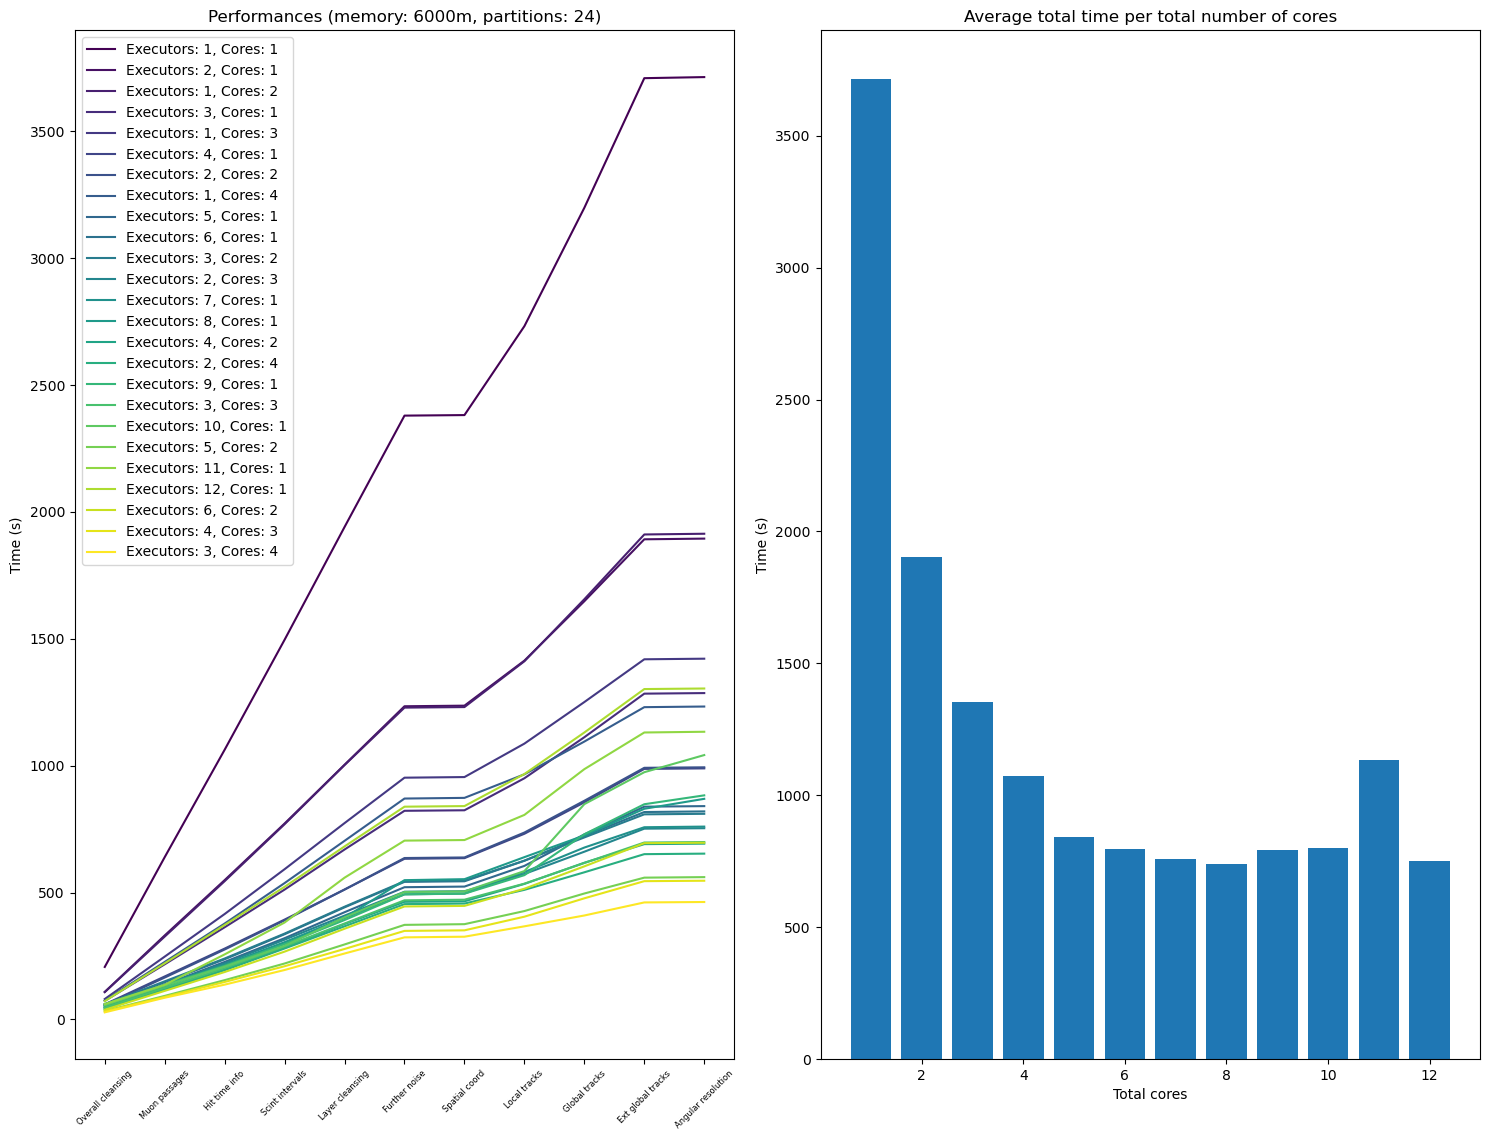

In [26]:
data = get_data("/usr/local/spark/Project/Benchmarking/Runs_ExecutorsCores")

executors  = [1, 2, 1, 3, 1, 4, 2, 1, 5, 6, 3, 2, 7, 8, 4, 2, 9, 3, 10, 5, 11, 12, 6, 4, 3]
cores      = [1, 1, 2, 1, 3, 1, 2, 4, 1, 1, 2, 3, 1, 1, 2, 4, 1, 3, 1, 2, 1, 1, 2, 3, 4]
max_cores  = [1, 2, 2, 3, 3, 4, 4, 4, 5, 6, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 11, 12, 12, 12, 12]
memory     = ["6000m"]
partitions = [24]

confs = get_confs(executors, cores, max_cores, memory, partitions)

executors_and_cores_plot(confs, h = 11.5)

The color of the plot is given following the configurations as listed above. We can notice that, overall, the performance increases when the total number of cores increases, as expected.

Since it's clear that fewer cores give the worst performances we decided to re-plot the same thing considering only the configurations with a total number of cores greater than $5$.

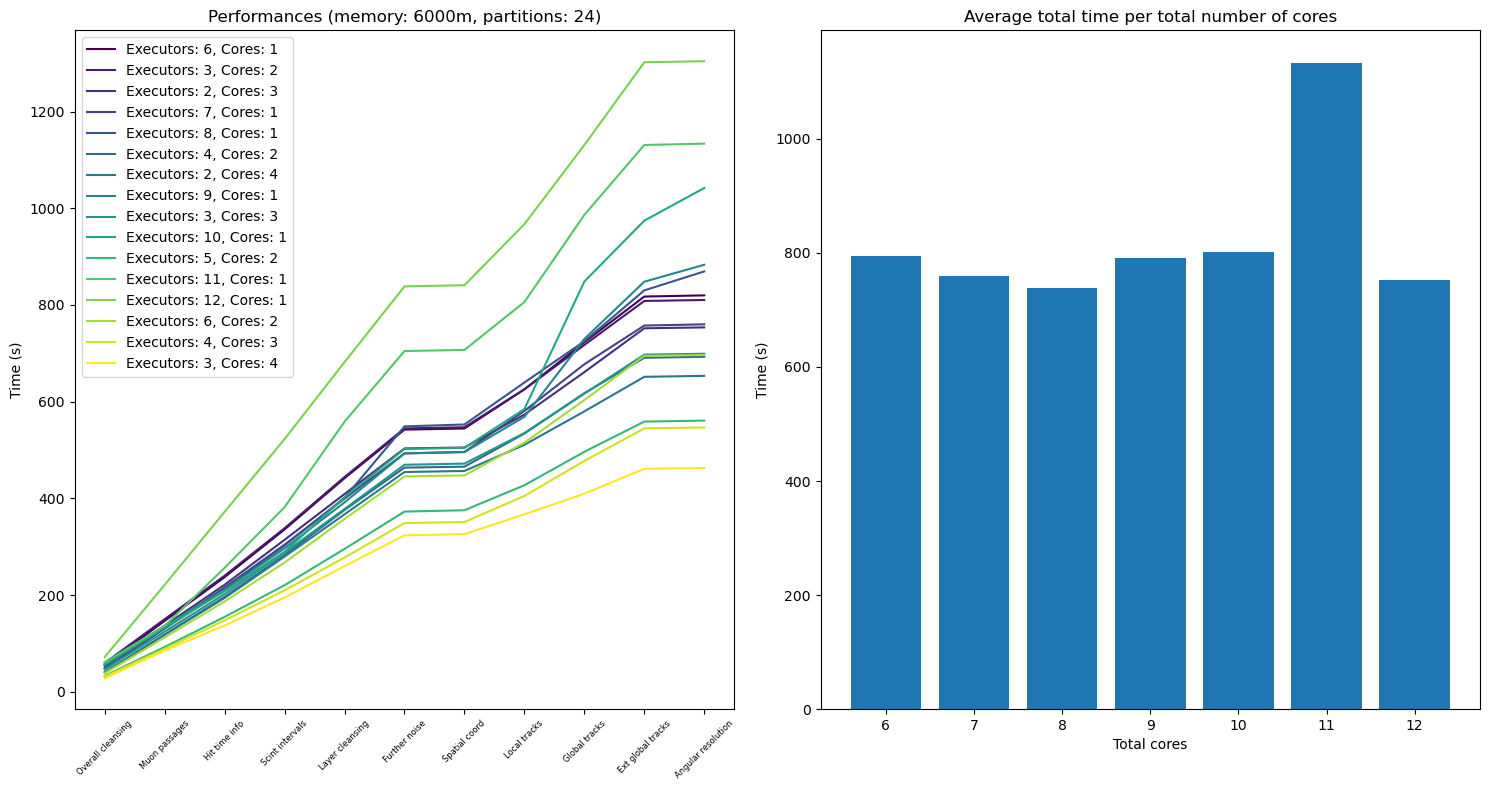

In [28]:
executors  = [6, 3, 2, 7, 8, 4, 2, 9, 3, 10, 5, 11, 12, 6, 4, 3]
cores      = [1, 2, 3, 1, 1, 2, 4, 1, 3, 1, 2, 1, 1, 2, 3, 4]
max_cores  = [6, 6, 6, 7, 8, 8, 8, 9, 9, 10, 10, 11, 12, 12, 12, 12]
memory     = ["6000m"]
partitions = [24]

confs = get_confs(executors, cores, max_cores, memory, partitions)

executors_and_cores_plot(confs, h = 8)

A part from the outsider configuration of $11$ cores, all the cores seems to have the same performances on average. If we have a closer look at the plot on the left we can observe that, for the same number of cores, the total time tends to decrease when the number of executors decreases. This is more clear if we explore the case of $8$ executors and $12$ executors, that appear to be the best ones in term of computation.

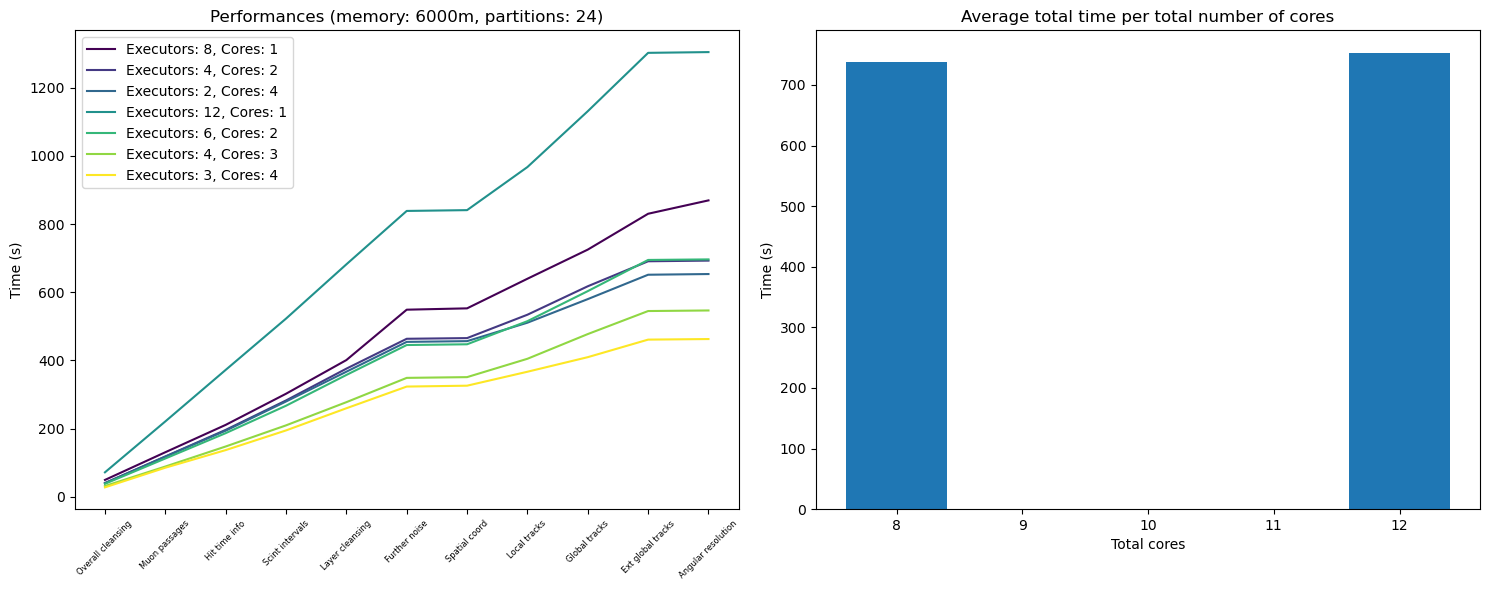

In [31]:
executors  = [8, 4, 2, 12, 6, 4, 3]
cores      = [1, 2, 4, 1, 2, 3, 4]
max_cores  = [8, 8, 8, 12, 12, 12, 12]
memory     = ["6000m"]
partitions = [24]

confs = get_confs(executors, cores, max_cores, memory, partitions)

executors_and_cores_plot(confs, h = 6)

Evene if, on average, the performances are similar, from the plot we can see that both the best and worst cases are associated to the $12$ total cores: the worst one (by far) is the one with $12$ executors with $1$ core, while the best one is the one with $3$ executors with $4$ cores.

This tells us that considering the average of all the configuration swith the same number of cores can actually be misleading, since every configuration performance can vary a lot. We then decided to plot only one configuration per total number of cores, which is the one with the lowest number of executors (and, of course, the highest number of cores per executor).

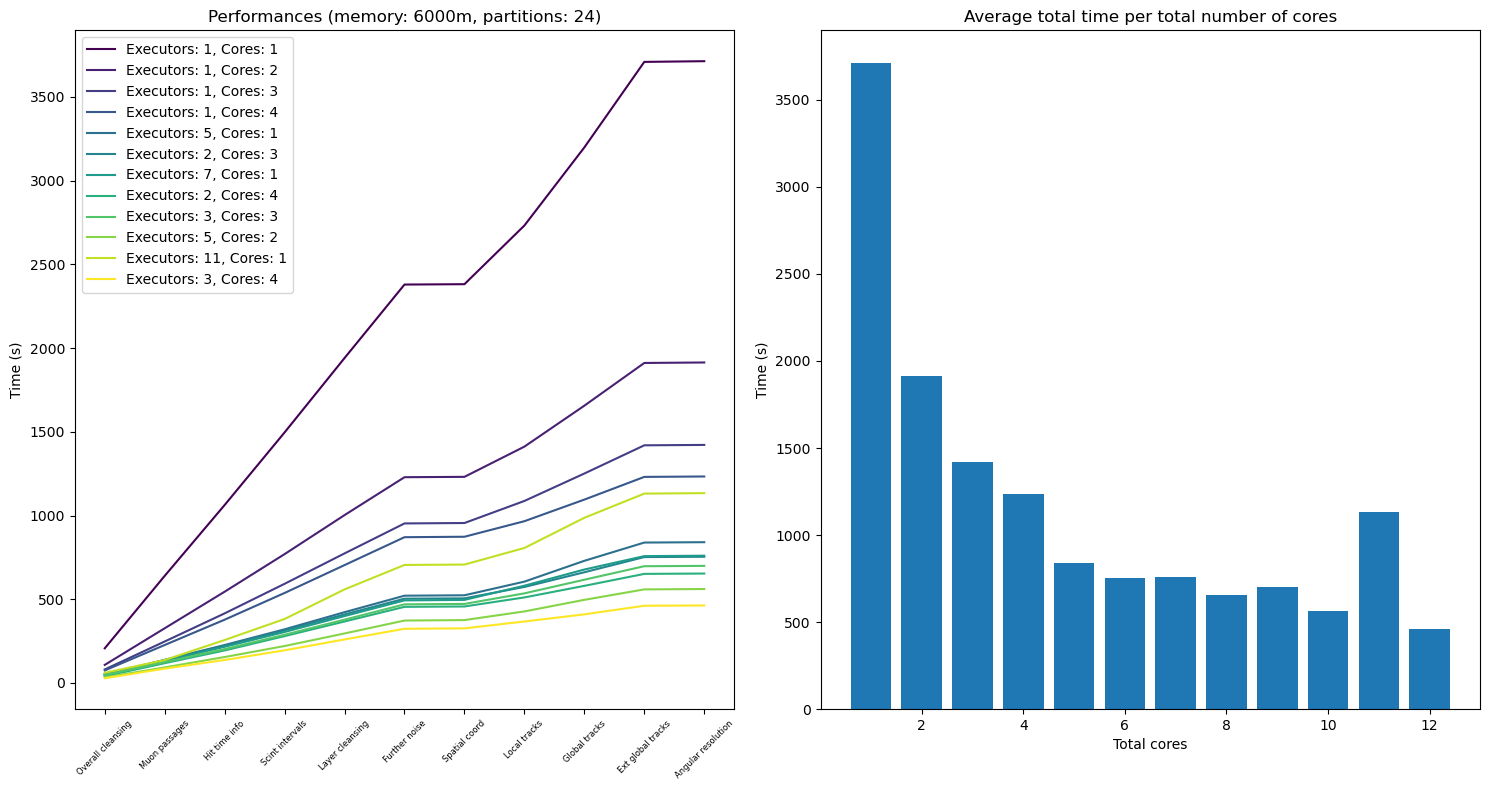

In [35]:
executors  = [1, 1, 1, 1, 5, 2, 7, 2, 3, 5, 11, 3]
cores      = [1, 2, 3, 4, 1, 3, 1, 4, 3, 2, 1, 4]
max_cores  = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
memory     = ["6000m"]
partitions = [24]

confs = get_confs(executors, cores, max_cores, memory, partitions)

executors_and_cores_plot(confs, h = 8)

The only outsider is the $11$ cores configuration also in this case, since it has no other possibility than $1$ core per executor. For the rest, the graph clearly shows a descent as the number of cores increases. For the following analysis we will consider the best configuration selected from what we have seen, which is the one with $3$ executors with $4$ cores.

## Cores and partitions analysis

Now we want to have a look to the number of partitions in which Spark handles shuffle operations. Since the total number of cores we are using is $12$, we assume that the ideal number of partitions is a multiple of $12$, but in order not to be too strict we decided to try different numbers with a step of $6$ instead of $12$. Also, since we want to further explore the performances related to the number of cores, we tried all possible $4$ configurations for each number of partitions.

In [40]:
def cores_and_partitions_plot(confs):

    fig = plt.figure(figsize=(15, 8))
    gs = gridspec.GridSpec(2, 12)

    for i, x_lab in enumerate(x_labels):
        
        lst_heatmap = []
    
        for c in confs:
            conf_str = "E" + str(c[0]) + "-C" + str(c[1]) + "-MC" + str(c[2]) + "-M" + str(c[3]) + "-P" + str(c[4]) + ".txt"
            lst_heatmap.append([c[1], c[4], data[conf_str][i]])

        df_heatmap = pd.DataFrame(lst_heatmap, columns=['Cores', 'Partitions', 'Time'])
        pivot_table = df_heatmap.pivot(index = "Cores", columns = "Partitions", values = "Time")

        if i < 6:
            ax = plt.subplot(gs[0, 2 * i:2 * i + 2])
            sns.heatmap(pivot_table, ax = ax, cbar = False, cmap = "magma_r", fmt = ".1f")
            ax.set_title(x_lab)
        else:
            ax = plt.subplot(gs[1, 2 * i - 11:2 * i + 2 - 11])
            sns.heatmap(pivot_table, ax = ax, cbar = False, cmap = "magma_r", fmt = ".1f")
            ax.set_title(x_lab)

    plt.tight_layout()
    plt.show()

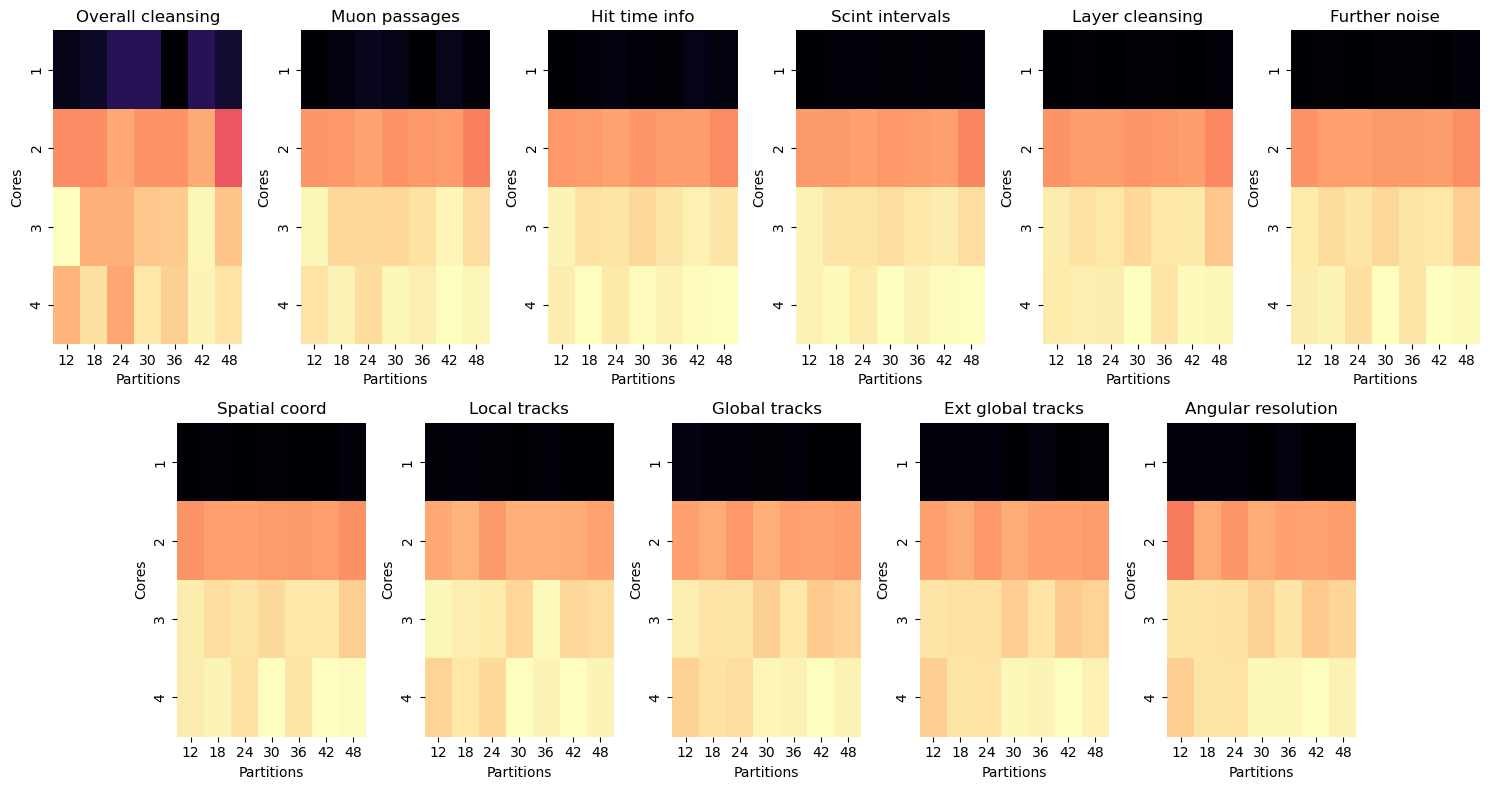

In [42]:
data = get_data("/usr/local/spark/Project/Benchmarking/Runs_CoresPartitions")

executors  = [3, 3, 3, 3]
cores      = [1, 2, 3, 4]
max_cores  = [3, 6, 9, 12]
memory     = ["6000m"]
partitions = [12, 18, 24, 30, 36, 42, 48]

confs = get_confs(executors, cores, max_cores, memory, partitions)

cores_and_partitions_plot(confs)

The eleven heatmaps shows the different configurations for each step in the algorithm. Since they appear to be very similar to each other, we decided to plot only the last one, which is the one related to the total time of the run.

In [44]:
def cores_and_partitions_lonely_plot(confs):

    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
        
    lst_heatmap = []
    
    for c in confs:
        conf_str = "E" + str(c[0]) + "-C" + str(c[1]) + "-MC" + str(c[2]) + "-M" + str(c[3]) + "-P" + str(c[4]) + ".txt"
        lst_heatmap.append([c[1], c[4], data[conf_str][-1]])

    df_heatmap = pd.DataFrame(lst_heatmap, columns=['Cores', 'Partitions', 'Time'])
    pivot_table = df_heatmap.pivot(index = "Cores", columns = "Partitions", values = "Time")
    sns.heatmap(pivot_table, ax = ax[0], annot = True, cmap = "magma_r", fmt = ".1f")

    mean_ts = []

    for i in range(0, 28, 7):
        v = 0
        for j in range(i, i+7):
            v += lst_heatmap[j][-1]

        mean_ts.append(v / 7)

    ax[1].plot(range(1, len(mean_ts)+1), mean_ts, marker = 'o')
    ax[1].set_xlabel("Cores")
    ax[1].set_ylabel("Time (s)")
    ax[1].set_title("Average total time per number of cores")

    plt.show()

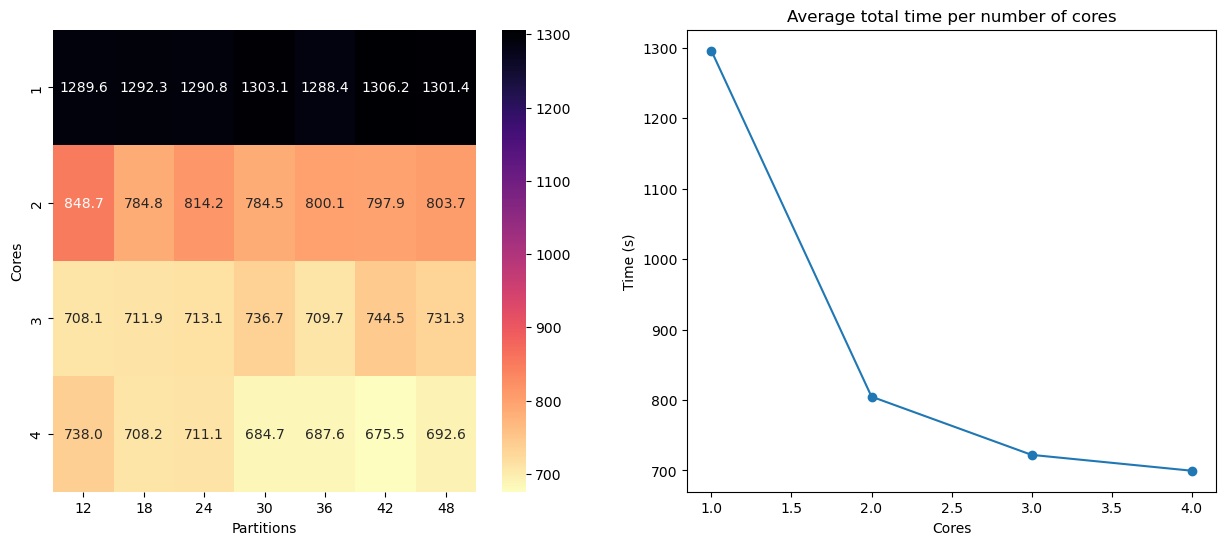

In [45]:
cores_and_partitions_lonely_plot(confs)

Here we can have a closer look to the heatmap. As expected, the computational time decreases with respect to the number of cores, as it is possible to observe in the plot on the right that takes the average time value for each number of cores.

Looking at the last row of the heatmap, we can see that the best performance is given by using $42$ partitions, even though the value doesn't vary too much, a part maybe for the $12$ partitions case which is the highest. For the final part of our analysis we will then use $42$ as the number of partitions.

## Memory analysis

The last thing we are interested into is how the performance varies with respect to the memory given for each executor. We decided to explore all the sizes from $1500 \ MB$ to $6500 \ MB$ with a step of $500 \ MB$.

In [51]:
def memory_plot(confs, w = 15, h = 8):

    fig, ax = plt.subplots(1, 2, figsize=(w, h))
    colors = plt.cm.viridis(np.linspace(0, 1, len(confs)))

    lst = []
    ms  = []

    for i, c in enumerate(confs):
        conf_str = "E" + str(c[0]) + "-C" + str(c[1]) + "-MC" + str(c[2]) + "-M" + str(c[3]) + "-P" + str(c[4]) + ".txt"
        ms.append(c[3][:4])
        lst.append(data[conf_str][-1])

        ax[0].plot(x_labels, data[conf_str], color = colors[i], label = f"Memory: {c[3]}")

    ax[0].tick_params(axis='x', labelsize=6, rotation=45)
    ax[0].set_ylabel("Time (s)")
    ax[0].set_title(f"Performances (executors: {confs[0][0]}, cores: {confs[0][1]}, partitions: {confs[0][4]})")
    ax[0].legend()

    ax[1].plot(ms, lst, marker = 'o')
    ax[1].set_xlabel("Memory (MB)")
    ax[1].set_ylabel("Time (s)")
    ax[1].set_title("Average total time per memory")

    plt.show()

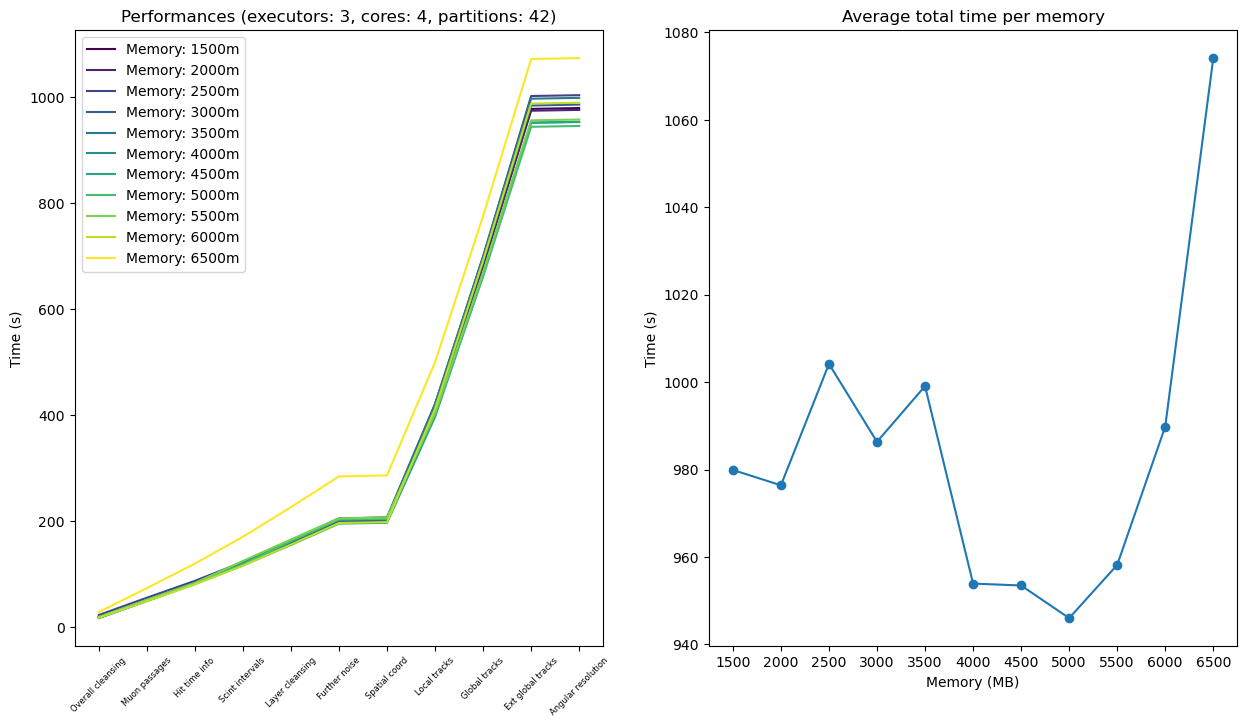

In [53]:
data = get_data("/usr/local/spark/Project/Benchmarking/Runs_Memory")

executors  = [3]
cores      = [4]
max_cores  = [12]
memory     = ["1500m", "2000m", "2500m", "3000m", "3500m", "4000m", "4500m", "5000m", "5500m", "6000m", "6500m"]
partitions = [42]

confs = get_confs(executors, cores, max_cores, memory, partitions)

memory_plot(confs)

On the right, we can see how the total computation time changes with memory size. There does not seem to be a clear trend or pattern, as the best case ($5000 \ MB$) happens to be in a minimum, so it is better than both the previous and the following cases. The only outlier is the $6500 \ MB$ case: we suppose that it is due to the residual memory that can be allocated on the workers. This memory is used by the workers to keep and manage the cluster and the links inside of it, so if it is not enough it may negatively impact on the performances.

Recall that we are currently using the persists in our algorithm. We know that the persists are used to dedicate a part of the memory to cache the data we are working on in order to speed up computations. Of course, this is a trade-off: the persists are useful only when the data is not too big in size, since part of the memory that could be used for calculation is now dedicated to store objects. Because of this, we thought it could be helpuful to see what would be the differences in the performances without using them. Below we can see the results.

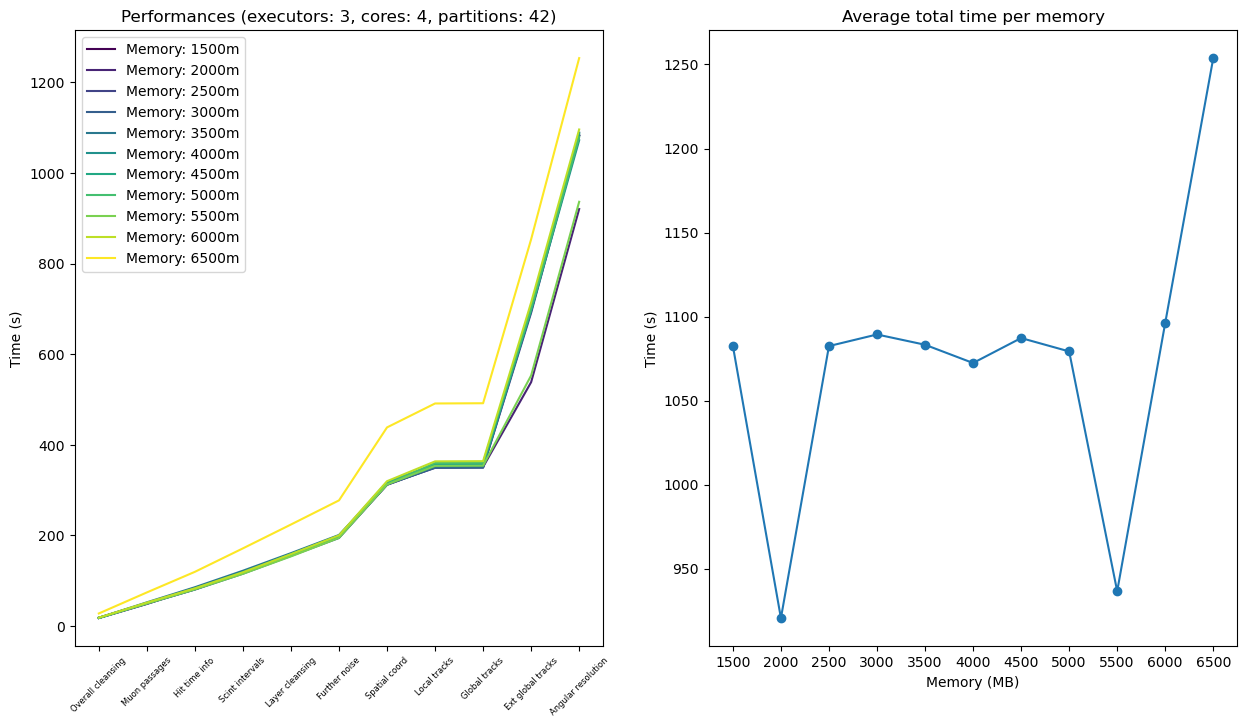

In [56]:
data = get_data("/usr/local/spark/Project/Benchmarking/Runs_MemoryNoDFNoLocalNoGlobal")
memory_plot(confs)

We can see that there are two configurations that are clearly better than the others: the $2000 \ MB$ one and the $5500 \ MB$ one. Once again, the worst configuration (by far) is the $6500 \ MB$ one, prooving once again the point above.

In the code we persisted three dataframes:

1. `df` that contains all the data filtered
2. `df_local` that containts all the local fits
3. `df_global` that containts all the global fits

The last two are useful for the last point of the analysis, which is the detector angular resolution, while `df` is used for the creation of `df_local` and also for the extended global fit. We then decided to also plot two "intermediate" configurations:

* Persisting `df` but not persisting `df_local` and `df_global`
* Not persisting `df` but persisting `df_local` and `df_global`

We can see both of them below.

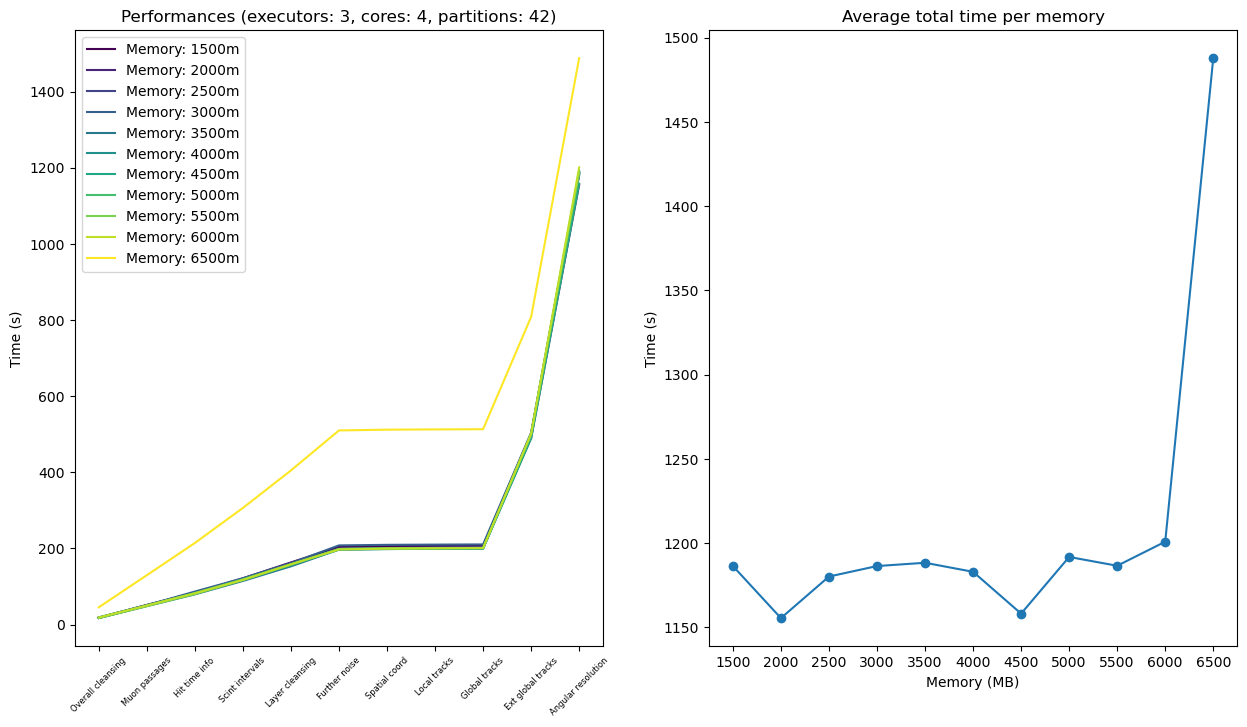

In [61]:
data = get_data("/usr/local/spark/Project/Benchmarking/Runs_MemoryNoLocalNoGlobal")
memory_plot(confs)

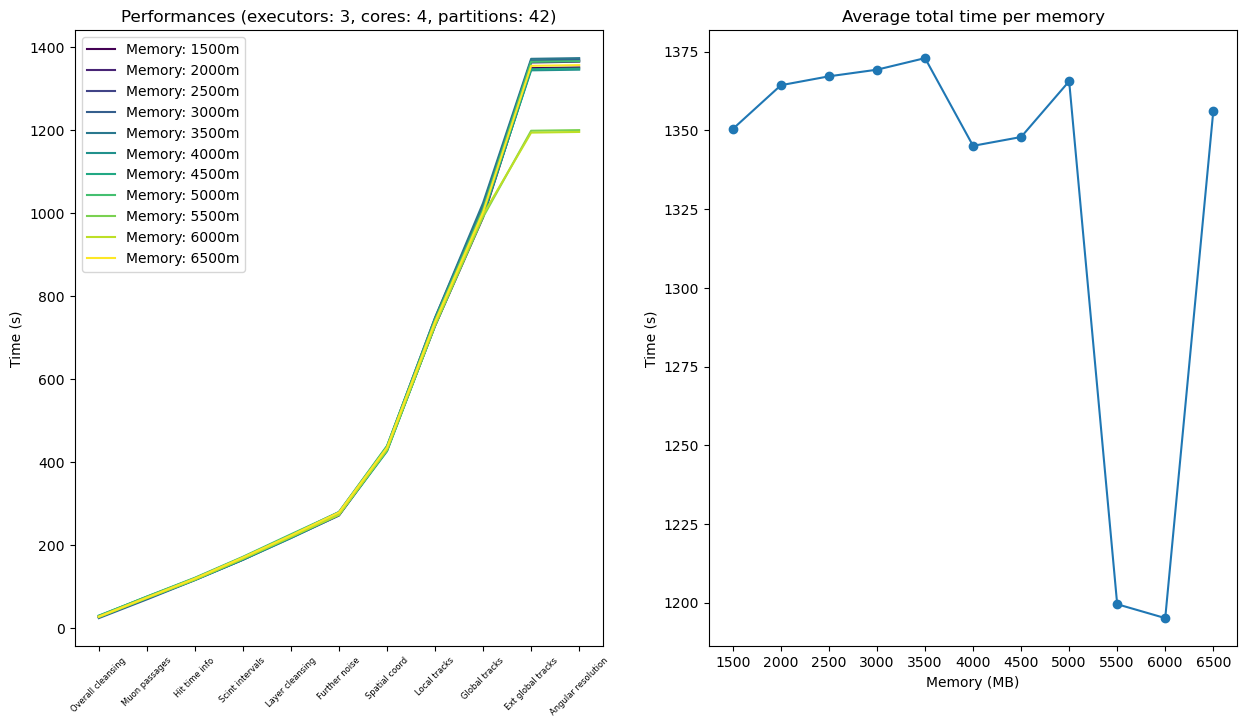

In [62]:
data = get_data("/usr/local/spark/Project/Benchmarking/Runs_MemoryNoDF")
memory_plot(confs)

To observe a direct comparison between the four different approach of persisting data we have created another function that plots the four cases for each size of memory that we have used.

In [65]:
def memory_direct_comparison(dirs, mems):

    datas = []

    for dir in dirs:
        datas.append(get_data("/usr/local/spark/Project/Benchmarking/Runs_Memory" + dir))

    data_to_plot = {m: [] for m in mems}

    for data in datas:
        for file in data:
            data_to_plot[file[12:17]].append(data[file])

    fig = plt.figure(figsize=(15, 18))
    gs = gridspec.GridSpec(4, 3)
    labels = ["Persist of df, df_local, df_global", "No persist", "Persist of df", "Persist of df_local and df_global"]

    for i, m in enumerate(mems):
        if i < 9:
            ax = plt.subplot(gs[i // 3, i % 3])
            for el, l in zip(data_to_plot[m], labels):
                ax.plot(x_labels, el, label = l)
                ax.tick_params(axis = 'x', labelsize = 8)
                plt.xticks(rotation = 45)
                ax.set_title(f"Memory: {m}")
                ax.set_ylabel("Time (s)")
                ax.legend()
                
            
        else:
            ax = plt.subplot(gs[3, i % 3])
            for el, l in zip(data_to_plot[m], labels):
                ax.plot(x_labels, el, label = l)
                ax.tick_params(axis = 'x', labelsize = 8)
                plt.xticks(rotation = 45)
                ax.set_title(f"Memory: {m}")
                ax.set_ylabel("Time (s)")
                ax.legend()

    plt.tight_layout()
    plt.plot()

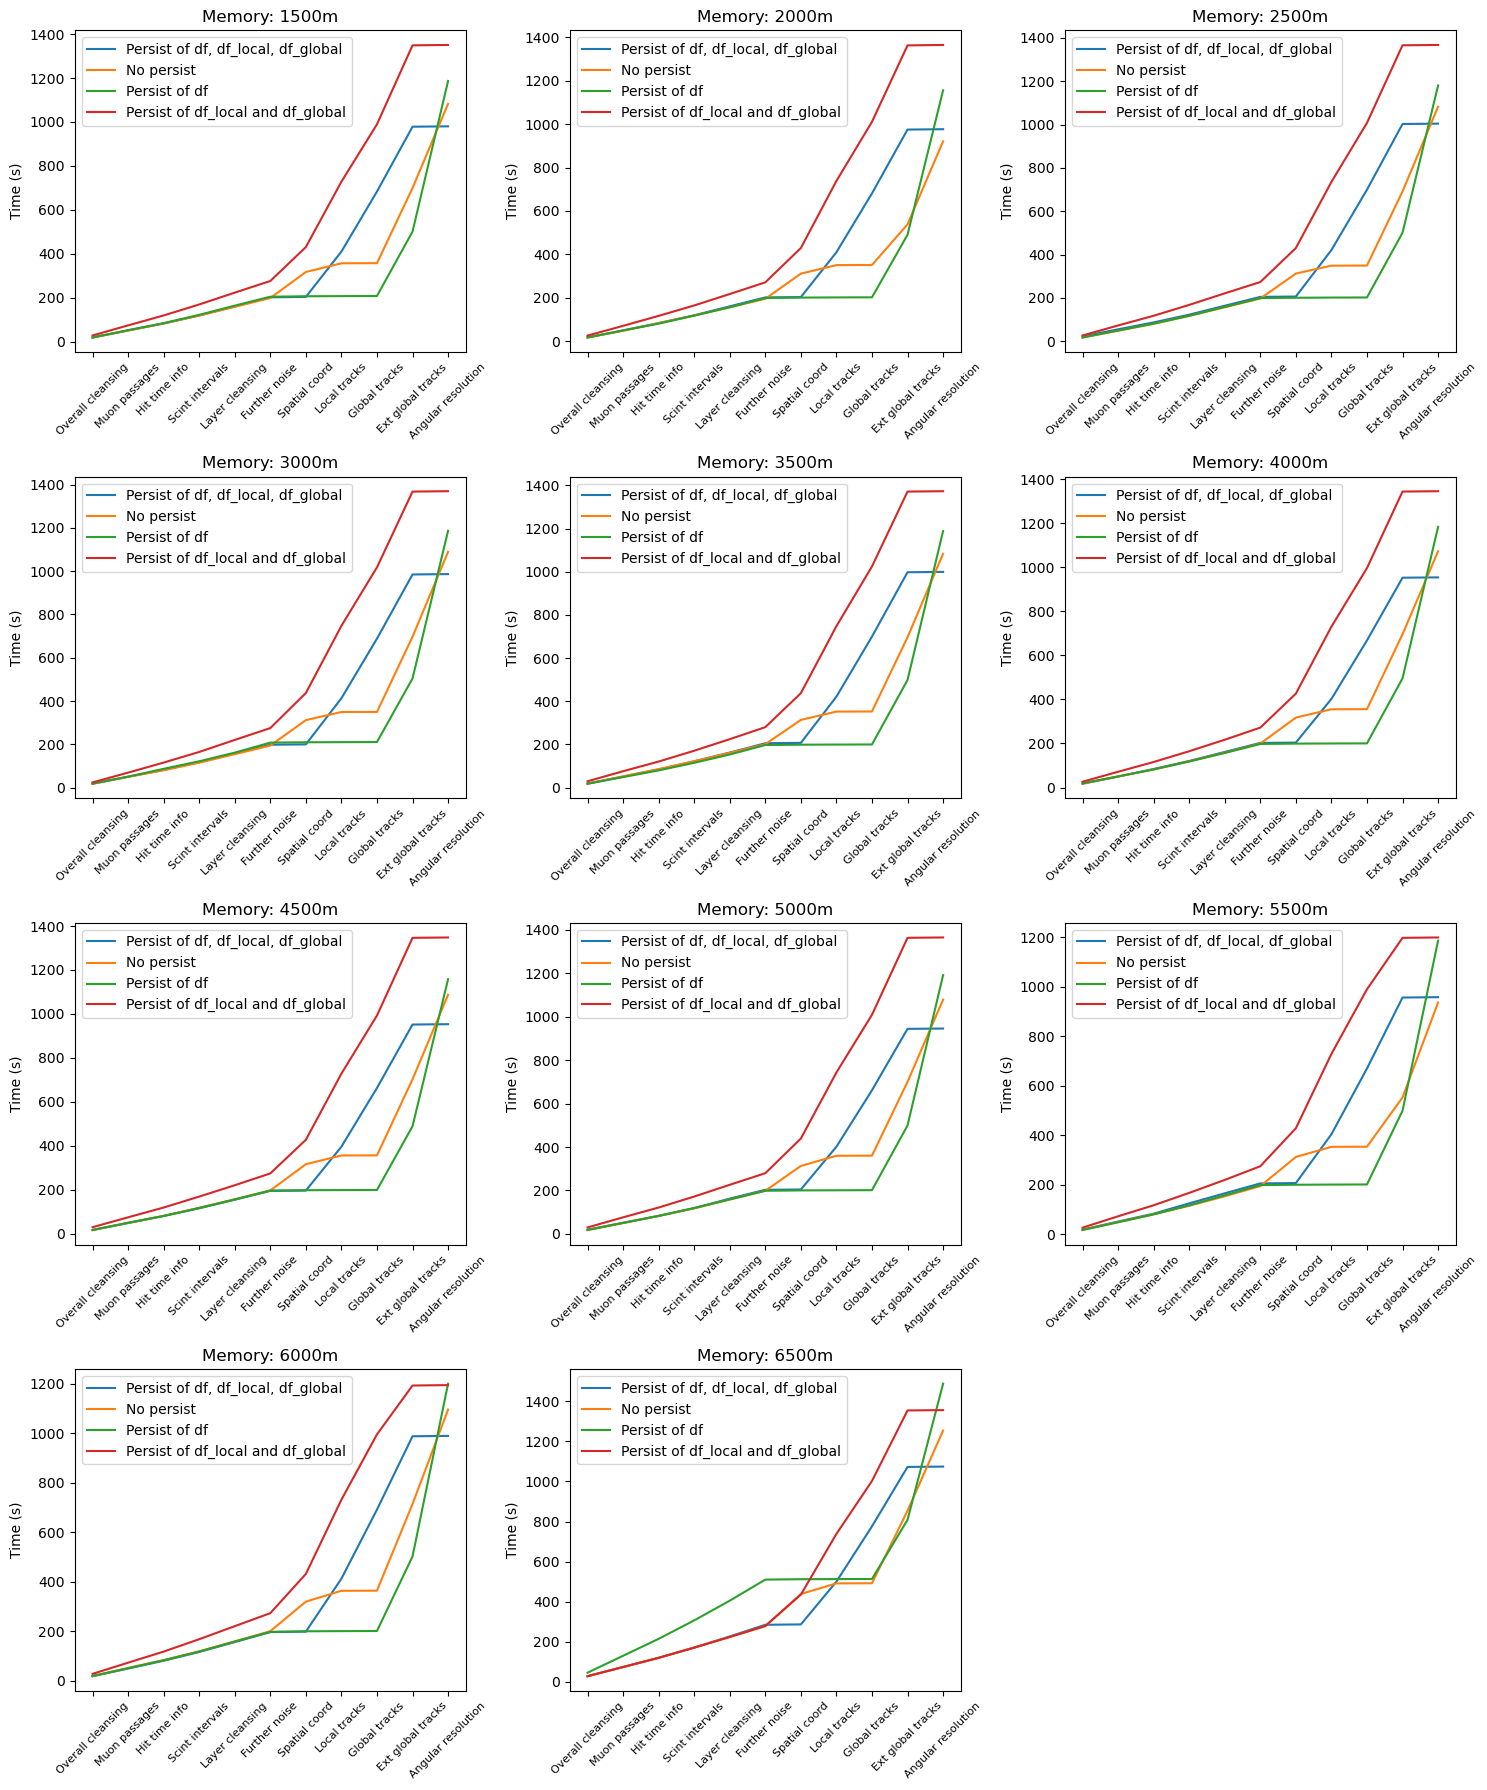

In [68]:
dirs = ["", "NoDFNoLocalNoGlobal", "NoLocalNoGlobal", "NoDF"]
mems = ["1500m", "2000m", "2500m", "3000m", "3500m", "4000m", "4500m", "5000m", "5500m", "6000m", "6500m", ]

memory_direct_comparison(dirs, mems)

***End of file.***